<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/(Not_Normal)Strong_STL_10__DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import utils
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import time
import os

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [3]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [4]:
def Get_psnr(input, output, max_val=255):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().clone().detach().numpy()
    output = output.cpu().clone().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [5]:
batch_size = 16
torch.manual_seed(1)
torch.cuda.manual_seed(1)


In [6]:
w_transform = transforms.Compose([
                    transforms.PILToTensor(),
                    transforms.ConvertImageDtype(torch.uint8),
])

In [7]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 80,000, 10,000, 8,000

tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = w_transform, download=True)

Files already downloaded and verified


In [8]:
tr_subset, val_subset = torch.utils.data.random_split(tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
test_set = datasets.STL10(root = "./data", split = "test",transform = w_transform, download=True)


Files already downloaded and verified


In [9]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)
val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 4, pin_memory=True)
test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 4, pin_memory=True)


In [10]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


In [11]:
img_train_set = tr_subset.dataset.data[tr_subset.indices]
label_train_set = tr_subset.dataset.labels[tr_subset.indices]

img_val_set = val_subset.dataset.data[val_subset.indices]
label_val_set = val_subset.dataset.labels[val_subset.indices]

img_test_set = test_set.data
label_test_set = test_set.labels

In [12]:
img_val_set.shape

(20000, 3, 96, 96)

In [13]:
img_val_set

array([[[[140, 132, 124, ..., 107, 106, 104],
         [135, 121, 117, ..., 115, 113, 113],
         [130, 115, 116, ..., 119, 119, 120],
         ...,
         [213, 197, 138, ..., 173, 164, 164],
         [213, 180, 129, ..., 170, 168, 172],
         [207, 155, 122, ..., 170, 172, 176]],

        [[193, 192, 187, ..., 110, 109, 106],
         [194, 181, 181, ..., 118, 116, 116],
         [193, 178, 177, ..., 122, 122, 123],
         ...,
         [196, 171, 136, ..., 180, 171, 172],
         [192, 164, 135, ..., 177, 175, 179],
         [185, 150, 133, ..., 175, 180, 184]],

        [[248, 251, 251, ...,  94,  93,  91],
         [250, 252, 252, ..., 100,  97,  97],
         [252, 255, 255, ..., 103, 103, 104],
         ...,
         [187, 157, 142, ..., 188, 178, 175],
         [177, 157, 154, ..., 184, 181, 184],
         [171, 155, 151, ..., 179, 181, 188]]],


       [[[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ..., 

In [14]:
label_val_set #No Label

array([-1, -1, -1, ..., -1, -1, -1])

In [15]:
img_test_set.shape

(8000, 3, 96, 96)

In [16]:
label_test_set

array([6, 7, 5, ..., 8, 8, 8], dtype=uint8)

In [17]:
label_test_set
img_test_set

array([[[[227, 227, 226, ..., 229, 228, 229],
         [227, 226, 228, ..., 228, 229, 228],
         [227, 227, 227, ..., 228, 229, 229],
         ...,
         [222, 227, 231, ..., 170, 196, 199],
         [233, 213, 202, ..., 203, 206, 194],
         [224, 225, 224, ..., 196, 179, 174]],

        [[235, 235, 236, ..., 233, 234, 235],
         [235, 235, 235, ..., 233, 233, 234],
         [235, 236, 236, ..., 233, 233, 233],
         ...,
         [174, 184, 186, ..., 147, 163, 167],
         [192, 174, 163, ..., 168, 167, 158],
         [181, 184, 184, ..., 153, 146, 138]],

        [[237, 237, 237, ..., 236, 236, 235],
         [237, 237, 237, ..., 236, 236, 234],
         [237, 236, 235, ..., 236, 236, 235],
         ...,
         [115, 119, 120, ..., 114, 122, 135],
         [133, 121, 109, ..., 126, 121, 114],
         [131, 130, 134, ..., 104, 107, 101]]],


       [[[ 86, 100, 104, ..., 114, 118, 116],
         [ 82,  92, 102, ..., 109, 119, 119],
         [ 74,  86,  96, ..., 

In [18]:
img_train_set_arr = np.array(img_train_set)
img_val_set_arr = np.array(img_val_set)
img_test_set_arr = np.array(img_test_set)

In [20]:
img_train_set

array([[[[ 28,  30,  32, ...,  45,  50,  44],
         [ 27,  27,  29, ...,  45,  50,  44],
         [ 29,  26,  28, ...,  44,  52,  42],
         ...,
         [ 85,  83,  82, ...,  86,  86,  85],
         [ 87,  86,  84, ...,  82,  80,  81],
         [ 92,  90,  88, ...,  88,  85,  86]],

        [[ 25,  25,  26, ...,  42,  47,  41],
         [ 23,  22,  25, ...,  42,  47,  41],
         [ 25,  22,  25, ...,  41,  49,  39],
         ...,
         [ 83,  81,  81, ...,  85,  85,  84],
         [ 82,  83,  83, ...,  81,  79,  80],
         [ 86,  85,  87, ...,  87,  84,  85]],

        [[ 57,  61,  61, ...,  73,  78,  72],
         [ 51,  54,  58, ...,  73,  78,  72],
         [ 49,  47,  55, ...,  72,  80,  70],
         ...,
         [ 88,  88,  87, ...,  90,  90,  89],
         [ 88,  88,  88, ...,  86,  84,  85],
         [ 90,  90,  92, ...,  92,  89,  90]]],


       [[[ 29,  28,  36, ...,  99,  91,  78],
         [ 68,  77,  92, ..., 219, 197, 173],
         [ 71,  84,  98, ..., 

In [19]:
img_train_set_arr

array([[[[ 28,  30,  32, ...,  45,  50,  44],
         [ 27,  27,  29, ...,  45,  50,  44],
         [ 29,  26,  28, ...,  44,  52,  42],
         ...,
         [ 85,  83,  82, ...,  86,  86,  85],
         [ 87,  86,  84, ...,  82,  80,  81],
         [ 92,  90,  88, ...,  88,  85,  86]],

        [[ 25,  25,  26, ...,  42,  47,  41],
         [ 23,  22,  25, ...,  42,  47,  41],
         [ 25,  22,  25, ...,  41,  49,  39],
         ...,
         [ 83,  81,  81, ...,  85,  85,  84],
         [ 82,  83,  83, ...,  81,  79,  80],
         [ 86,  85,  87, ...,  87,  84,  85]],

        [[ 57,  61,  61, ...,  73,  78,  72],
         [ 51,  54,  58, ...,  73,  78,  72],
         [ 49,  47,  55, ...,  72,  80,  70],
         ...,
         [ 88,  88,  87, ...,  90,  90,  89],
         [ 88,  88,  88, ...,  86,  84,  85],
         [ 90,  90,  92, ...,  92,  89,  90]]],


       [[[ 29,  28,  36, ...,  99,  91,  78],
         [ 68,  77,  92, ..., 219, 197, 173],
         [ 71,  84,  98, ..., 

In [19]:
print(len(tr_subset))

80000


In [20]:
time.sleep(5.0)

In [ ]:
img_train_set_arr

In [21]:
device = get_device()
Gs_blur_strong_tr_dataset = []
for i in range(80000):
  hat_img_train_set_arr = cv2.GaussianBlur(img_train_set_arr[i], (3,3),0)
  hat_img_train_set_tensor_byte = torch.from_numpy(hat_img_train_set_arr)
  hat_img_train_set_tensor_255 = torch.clamp(hat_img_train_set_tensor_byte,min=0,max=255)
  hat_img_train_set_tensor_float = hat_img_train_set_tensor_255.float()# .to(device) X, 데이터 로더에 pin_memory 설정 하면 된다. 
#  print("hat_img_train_set_tensor_float",hat_img_train_set_tensor_float)
#  hat_img_train_set_tensor_normal = hat_img_train_set_tensor_float.div(255.0)
#  print("hat_img_train_set_tensor_normal",hat_img_train_set_tensor_normal)
  
  Gs_blur_strong_tr_dataset.append([hat_img_train_set_tensor_float,0])

In [22]:
time.sleep(5.0)

In [23]:
Gs_blur_strong_val_dataset = []
for j in range(20000):
  hat_img_val_set_arr = cv2.GaussianBlur(img_val_set_arr[j],  (3,3),0)
  hat_img_val_set_tensor_byte = torch.from_numpy(hat_img_val_set_arr) #애초에 ToTensor로 데이터를 불러오지 않으면 from_numpy는 통하지 않는다. 아직 주소가 할당이 안 되었음
  hat_img_val_set_tensor_255 = torch.clamp(hat_img_val_set_tensor_byte,min=0,max=255)
  hat_img_val_set_tensor_float = hat_img_val_set_tensor_255.float()

#  hat_img_val_set_tensor_normal = hat_img_val_set_tensor_float.div(255.0)
  Gs_blur_strong_val_dataset.append([hat_img_val_set_tensor_float,0])

In [24]:
Gs_blur_strong_tr_dataloader = DataLoader(Gs_blur_strong_tr_dataset, batch_size = batch_size, num_workers = 4, pin_memory=True)
Gs_blur_strong_val_dataloader = DataLoader(Gs_blur_strong_val_dataset, batch_size = batch_size, num_workers = 4, pin_memory=True) 


print(torch.from_numpy(cv2.GaussianBlur(train_set_arr[i],(3,3),0).transpose(1,0,2)).float().div(255.0).shape)

Gaussian_blur_strong_tr_arr = np.array([])
y = np.array([])
GS = cv2.GaussianBlur(train_set_arr[1],(3,3),0)
Gaussian_blur_strong_tr_arr = np.append(Gaussian_blur_strong_tr_arr,GS)
print(y.shape)
print(Gaussian_blur_strong_tr_arr.shape)

print(type(GS))

print(Gaussian_blur_strong_tr_arr.shape)

type(Gaussian_blur_strong_tr_arr)

In [25]:
class DenosingAutoencoder(nn.Module):
  def __init__(self):
    super(DenosingAutoencoder, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
    #48 by 48 by 32
        nn.ReLU(True),


        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 

        nn.ReLU(True),

        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
    # 6 by 6 by 256
        nn.ReLU(True),
    )
    self.decoder = nn.Sequential(
 
        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 12 by 12 by 128  
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),
    # 24 by 24 by 64

        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.ReLU(True),        
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [26]:
time.sleep(5.0)

In [28]:
#Epochs
n_epochs = 5

device = get_device()
print(device)
model_strong = DenosingAutoencoder()
optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
model_strong=model_strong.to(device)

strong_train_loss_graph = np.array([])
strong_val_loss_graph = np.array([])




start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_strong.train()
    time.sleep(1.0)
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_loss = 0.0
    total_val_loss = 0.0

    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''
    #Training
    for i,(tr_img, hat_img) in enumerate(zip(tr_dataloader,Gs_blur_strong_tr_dataloader)):
        tr_images,_ = tr_img
#        print(tr_images_arr.shape)
        hat_tr_images,_ = hat_img
#check   print(type(hat_tr_images))
        hat_tr_images = hat_tr_images.to(device)
#check   print(tr_images.shape)
        tr_outputs =model_strong(hat_tr_images)
        optimizer_strong.zero_grad()
#check0. print(hat_tr_images.shape)  
#check   print(tr_outputs.shape)
        tr_images = tr_images.to(device)
        loss = mse_loss(tr_outputs, tr_images).to(device)
        loss.backward()
        optimizer_strong.step()
        train_loss = loss.clone().detach().item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_dataloader)
    strong_train_loss_graph = np.append(strong_train_loss_graph, total_train_loss)

    
    #evaluation
    model_strong.eval()
    time.sleep(1.0)
    with torch.no_grad():   
        optimizer_strong.zero_grad()
        
        for i, (img, hat_img) in enumerate(zip(val_dataloader, Gs_blur_strong_val_dataloader)):
                val_img, _ = img
                hat_val_img,_ = hat_img
                 
                hat_val_img = hat_val_img.to(device)
                val_outputs =model_strong(hat_val_img)
#                print('val_outputs shape:',val_outputs.shape )
                val_img = val_img.to(device)
                val_loss = mse_loss(val_outputs, val_img)
                val_loss = val_loss.detach().item()
                total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_dataloader)
        strong_val_loss_graph = np.append(strong_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
        if (epoch)%1 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().numpy().astype('uint8').transpose(1, 2, 0), val_outputs[j].cpu().numpy().astype('uint8').transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(val_img[j], val_outputs[j])
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(3,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().astype('uint8').transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3,5,j+5+1)
            plt.imshow(hat_val_img[j].cpu().numpy().astype('uint8').transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


            ax = plt.subplot(3, 5, j+5+5+1)
            plt.imshow(val_outputs[j].cpu().numpy().astype('uint8').transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()


total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

KeyboardInterrupt: ignored

In [ ]:
t_val_ssim = ssim(val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0), val_outputs[0].cpu().numpy().astype('uint8').transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
t_val_ssim

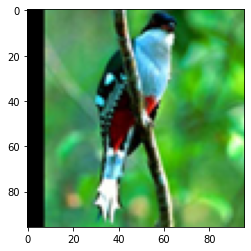

In [37]:
plt.imshow(val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0))

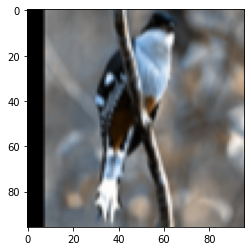

In [36]:
plt.imshow(hat_val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0))

In [ ]:
val_img[0].shape

In [ ]:
val_img[0].cpu().numpy().astype('uint8').transpose(1, 2, 0)

In [ ]:
plt.imshow(hat_val_img[j].cpu().numpy().astype(uint8).transpose(1, 2, 0))

In [ ]:
plt.imshow(hat_val_img[j].cpu().numpy().transpose(1, 2, 0)

In [ ]:
PATH1 = '/content/drive/MyDrive/model/model_strong.pth'
torch.save(model_strong.state_dict(), PATH1)

In [ ]:
a = torch.randn(4)
a


In [ ]:
torch.clamp(a, min=0, max=1)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(strong_train_loss_graph,'r-*')
plt.plot(strong_val_loss_graph, 'b-*')
plt.legend(['strong_train_loss','strong_val_loss'])
plt.title("Stl_10")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig('./strong_loss_graph.png')


# strong test

In [ ]:

Gs_blur_strong_test_dataset = []

for j in range(8000):
  hat_img_test_set_arr = cv2.GaussianBlur(img_test_set_arr[j], (41,41),0)
  hat_img_test_set_tensor_byte = torch.from_numpy(hat_img_test_set_arr)
  hat_img_test_set_tensor_float = hat_img_test_set_tensor_byte.float()
  hat_img_test_set_tensor_normal = hat_img_test_set_tensor_float.div(255.0)
  Gs_blur_strong_test_dataset.append([hat_img_test_set_tensor_normal,0])

Gs_blur_strong_test_dataloader = DataLoader(Gs_blur_strong_test_dataset, batch_size = batch_size, num_workers = 4)

# strong graph

# test graph for (average psnr, ssim)

In [ ]:
from skimage.metrics import structural_similarity as ssim

sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_strong.eval()
with torch.no_grad():
    optimizer_strong.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_strong_test_dataloader)):
        
        strong_test_img, _ = test_img
        strong_test_img = strong_test_img.to(device)
        strong_test_hat_img, _ = hat_test_img
        strong_test_hat_img = strong_test_hat_img.to(device)

        test_outputs = model_strong(strong_test_hat_img)
        
    for j in range(10):
        img1_cpu = strong_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        strong_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        strong_psnr = Get_psnr(strong_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=strong_psnr
        sum_ssim+=strong_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(strong_psnr,strong_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(strong_test_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(strong_test_hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(test_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))


In [ ]:
data = iter(Gs_blur_strong_val_dataloader)
img,_ = next(data)
img_uint8 = img[0].numpy().astype('uint8')

plt.imshow(img_uint8.transpose(1,2,0))
img[0]

In [ ]:
print(img[0].shape)